In [1]:
import numpy as np
import networkx as nx
import Graph
import Classifier
import matplotlib.pyplot as plt
from time import perf_counter
from datetime import timedelta
from gensim.models import Word2Vec
from multiprocessing import cpu_count

%matplotlib inline

In [2]:
#Open and parse dataset
G, subs_coo = Graph.parse_mat_file('blogcatalog.mat')

Name: blogcatalog.mat
Type: Graph
Number of nodes: 10312
Number of edges: 333983
Average degree:  64.7756
---------------------------------------



In [3]:
#Build corpus
print("\t**Stage 1 : Generating random walks**")
t1 = perf_counter()
corpus = Graph.build_walk_corpus(G=G, max_paths=30, path_len=40)
t2 = perf_counter()
print("\nNumber of walks in the corpus = ",len(corpus))
print("Time Elapsed for building walk corpus --> ", timedelta(seconds=t2-t1))
print("---------------------------------------\n")

	**Stage 1 : Generating random walks**
Building walk corpus with parameters : max_paths per node =  30  and path_length =  40
Completed

Number of walks in the corpus =  309360
Time Elapsed for building walk corpus -->  0:02:50.025881
---------------------------------------



In [5]:
#Train model
#ToDO: try negative sampling (hs=0)
print("\t**Stage 2 : Generating Embeddings for nodes using Word2Vec**")
print("\nWord2Vec parameters : Dimensions = 128, window = 10, number of cpu cores assigned for training = ",cpu_count())
t1 = perf_counter()
model = Word2Vec(size = 128, window=10, sg=1, min_count=0, hs=1, compute_loss=True, workers=cpu_count())
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=model.iter)
t2 = perf_counter()

#Save w2v embeddings
word_vec = model.wv
word_vec.save_word2vec_format(binary=False,fname='word2vec.txt')

print("Model training done. Word2Vec embeddings generated and saved in word2vec.txt")
print("Time Elapsed for generating embeddings --> ", timedelta(seconds=t2-t1))
print("---------------------------------------\n")

	**Stage 2 : Generating Embeddings for nodes using Word2Vec**

Word2Vec parameters : Dimensions = 128, window = 10, number of cpu cores assigned for training =  4


/Users/ass6ash/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Model training done. Word2Vec embeddings generated and saved in word2vec.txt
Time Elapsed for generating embeddings -->  0:21:04.031389
---------------------------------------



In [3]:
#Sometimes the model doesn't predict anything at all for some inputs. Its either the model's fault or that user has no subscriptions at
#all, in that case the model is predicting properly but of course a zero output would raise exceptions during sklearn's
#F1 score function.
#Currently evaluating performance with OVR Logistic Regression.
print("\t**Stage 3 : Evaluating classifier performance with the embeddings**")

t1 = perf_counter()
results = Classifier.evaluate(G, subs_coo)
t2 = perf_counter()

print("\n Evaluation completed using the following:")
for i in results.keys():
    print("--> ",i)
print("Time Elapsed for evaluation --> ", timedelta(seconds=t2-t1))
print("---------------------------------------\n")


	**Stage 3 : Evaluating classifier performance with the embeddings**


/Users/ass6ash/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ass6ash/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ass6ash/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ass6ash/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



 Evaluation completed using the following:
-->  Logistic_Regression
Time Elapsed for evaluation -->  0:00:28.663396
---------------------------------------



/Users/ass6ash/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ass6ash/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Printing evaluation results : 


Classifier :  Logistic_Regression
	Training size :  0.2
		Micro F1:  0.3776568170036288
		Macro F1:  0.2315693802086016
	Training size :  0.5
		Micro F1:  0.4015246015246015
		Macro F1:  0.26826858261898523
	Training size :  0.8
		Micro F1:  0.4201328206920657
		Macro F1:  0.29027617625378344
	Training size :  0.9
		Micro F1:  0.4223954642097803
		Macro F1:  0.27375958228590364
	---------------------------------------
	 Average Micro F1 :  0.40542742585751906
	 Average Macro F1 :  0.2659684303418185


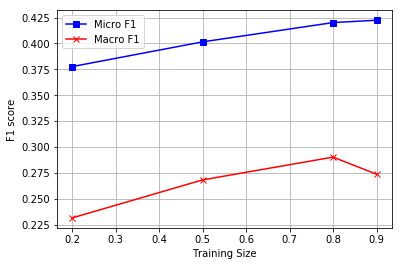

In [4]:
print("Printing evaluation results : ")
trainsize = [0.2, 0.5, 0.8, 0.9]
for (name,res) in results.items():
    print("\n\nClassifier : ",name)
    for (tr_size,res_) in zip(trainsize,res):
        print("\tTraining size : ",tr_size)
        print("\t\tMicro F1: ",res_[0])
        print("\t\tMacro F1: ",res_[1])
    
    avg = np.average(res,axis=0)
    print("\t---------------------------------------")
    print("\t Average Micro F1 : ",avg[0])
    print("\t Average Macro F1 : ",avg[1])
    Classifier.plot_graph(trainsize, res)
    print("====================================================\n")

In [ ]:
#Results don't quite match the ones in the paper. Might have to tune the parameters to get optimal performance.